<a href="https://colab.research.google.com/github/CPTR295/ML1/blob/main/MNIST_Classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MNIST - 70k images of digits handwritten by kids.

In [1]:
import numpy as np
import os

In [2]:
from sklearn.datasets import fetch_openml #since Scikit-Learn 0.24, fetch_openml() returns a Pandas DataFrame by default,use as_frame=False.
mnist = fetch_openml('mnist_784',version=1,as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X,y = mnist["data"],mnist['target'] #All scilearn datasets comes with DESCR - describe data sets, data - array of one row per intsance and targer - array of labels

In [4]:
X.shape #70k images with 784 featres = img = 28*28 pixel , pixel=0 white to 255 black

(70000, 784)

In [5]:
y.shape

(70000,)

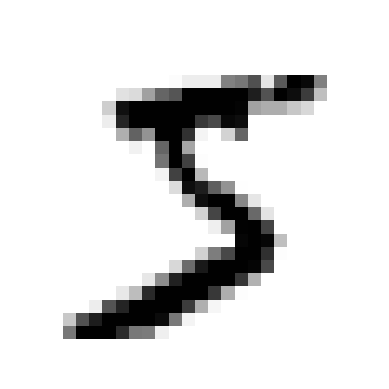

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()

In [7]:
y[0]

'5'

In [8]:
y=y.astype(np.uint8) #Covert str to int

In [9]:
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:] #sklearn already does split for last 10k

In [10]:
y_train_5 = (y_train==5) #For binary classification 5 and not 5
y_test_5 = (y_test==5)

In [11]:
from sklearn.linear_model import SGDClassifier #Stochastic Gradient Descent - Good for large datasets and online leaning , as it handles row intances independently

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)


SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

In [13]:
from sklearn.model_selection import StratifiedKFold  #Implementing cross validation or skip to use builtin functions
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) #if shuffle is false , then random state  is not required
for train_index,test_index in skfolds.split(X_train,y_train_5):
  clone_clf=clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_folds = X_train[test_index]
  y_test_folds = y_train_5[test_index]

  clone_clf.fit(X_train_folds,y_train_folds)
  y_pred = clone_clf.predict(X_test_folds)
  n_correct = sum(y_pred==y_test_folds)
  print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


In [14]:
from sklearn.model_selection import cross_val_score #accuracy is not a good measure here as only 10% od data is 5(Data is skewed)
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator): #basic claffier class which will return always false for 5
  def fit(self,X,y=None):
    pass
  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [17]:
from sklearn.model_selection import cross_val_predict #instead of score we get prediction

y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred) #Row is actual, col is predicted

array([[53892,   687],
       [ 1891,  3530]])

In [19]:
#precision = TP/(TP+FP)
#Recall/Sensitivity = TP/TP+FN

In [20]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5,y_train_pred) #When it claims an image is 5 , its correct only 83%

0.8370879772350012

In [21]:
recall_score(y_train_5,y_train_pred) #It can only detect 65% of 5s. Increasing precision reduces recall(precison_recall_tradeoff)

0.6511713705958311

In [22]:
from sklearn.metrics import f1_score #harmonic mean of precision and recall (2/(1/p)+(1/r))
f1_score(y_train_5,y_train_pred)

0.7325171197343847

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
threshold=0 #classfier use decision score and compare to threshold to give prediction.

In [25]:
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([ True])

In [26]:
threshold=8000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred


array([False])

In [27]:
y_scores=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')

In [28]:
from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds= precision_recall_curve(y_train_5,y_scores)

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

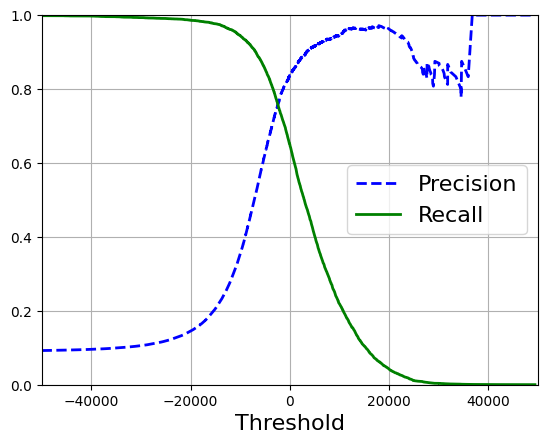

In [30]:
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

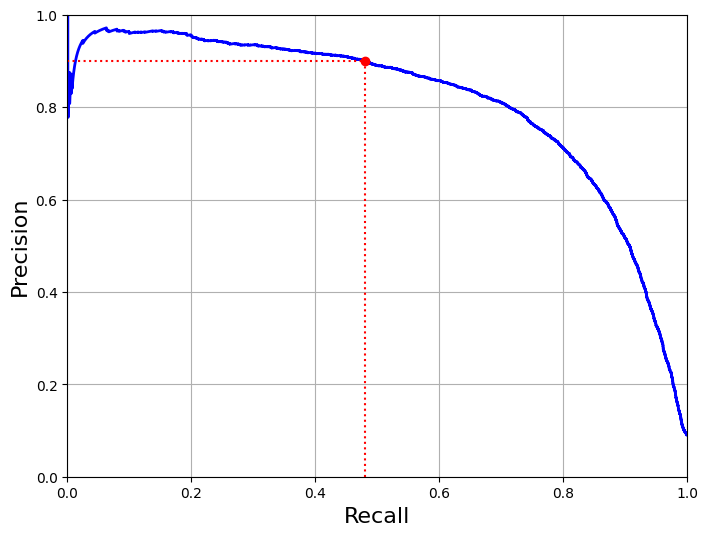

In [31]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [32]:
threshold_90_precision

np.float64(3370.0194991439557)

In [33]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [34]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [35]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [36]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

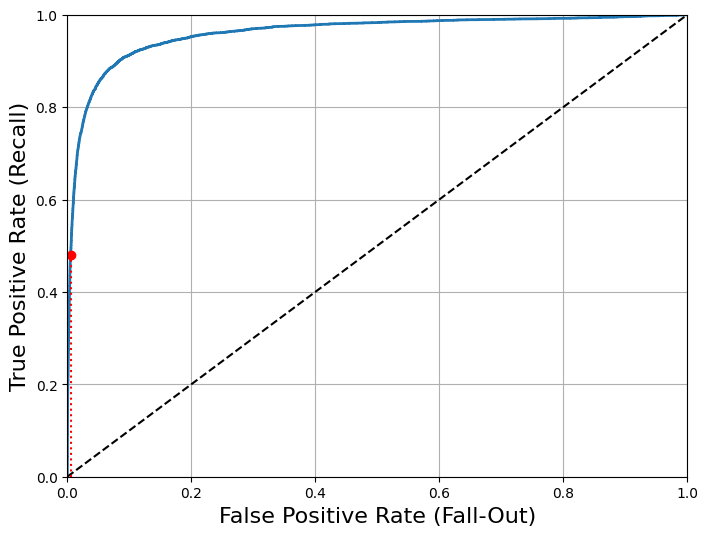

In [37]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()

In [38]:
from sklearn.metrics import roc_auc_score #perfect classifier=1 , random classifier=0.5

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [39]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [40]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

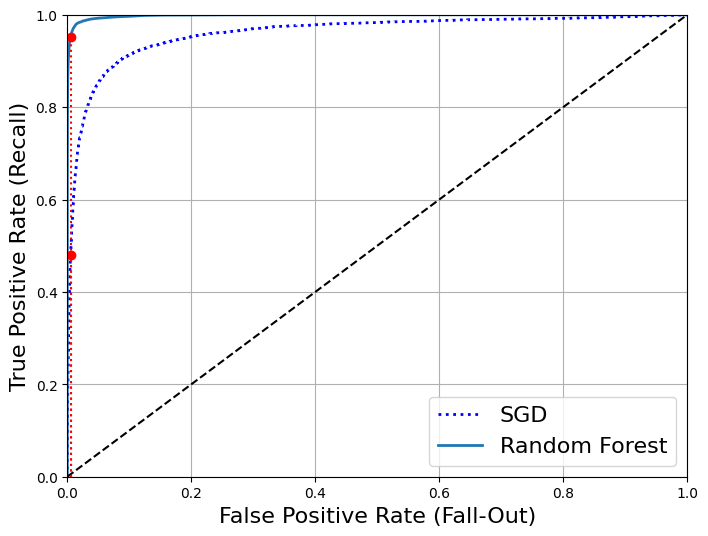

In [41]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [42]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

In [43]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [44]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

OvA - one versus all , train 10 binary classifiers for evry call
OvO - one vs one - train n*n-1/2 classifiers , and get best result
SVM - Good for small dataset , hence uses OvO , others prefer OvA

In [45]:
sgd_clf.fit(X_train,y_train) #it used OvA , and trained 10 binary models, select class with highest score
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [46]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [47]:
np.argmax(some_digit_scores) #get max

np.int64(3)

In [48]:
sgd_clf.classes_ #List of classes is stored in list

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [49]:
sgd_clf.classes_[3]

np.uint8(3)

In [50]:
from sklearn.multiclass import OneVsOneClassifier #To force OvO strategy
ovo_clf=OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train,y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [51]:
len(ovo_clf.estimators_) #Total models instances trained under hood

45

In [52]:
forest_clf.fit(X_train,y_train) #No OvA/OvO required as random forest can work of multi class
forest_clf.predict([some_digit])


array([5], dtype=uint8)

In [53]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [54]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [56]:
y_train_pred=cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

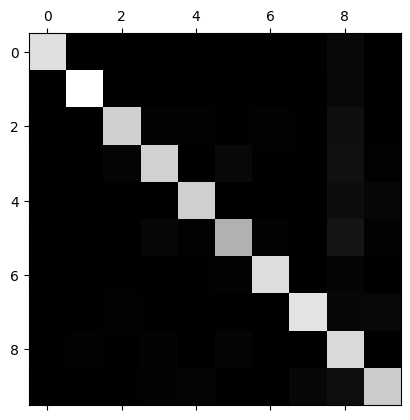

In [57]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

In [58]:
row_sums = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx/row_sums

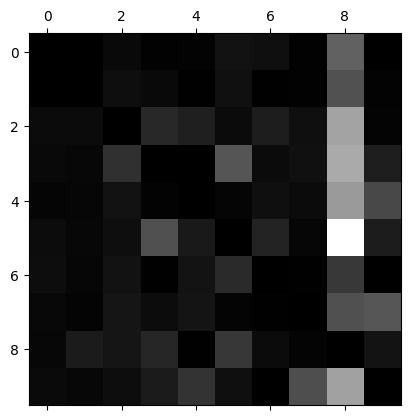

In [59]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()